In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader
import h5py # reccommended by the interpreter (weird) for loading older `.mat` files

/usr/lib/python3.11/site-packages/torchvision-0.15.2-py3.11-linux-x86_64.egg/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


# Importing the Dataset

In [5]:
class NYUDepthDataset (Dataset):
	def __init__(self, file_path, transform=None, target_transform=None):
		self.file_path = file_path
		self.data = h5py.File(file_path, 'r')
		self.transform = transform
		self.target_transform = target_transform

	def __len__(self):
		return len(self.data['images'])
	
	def __getitem__(self, idx):
		rgb_image = np.swapaxes(self.data['images'][idx], 0, 2)
		depth_image = np.swapaxes(self.data['depths'][idx], 0, 1)

		# print(rgb_image.shape)

		if self.transform:
			# print(torch.from_numpy(rgb_image).size())
			rgb_image = self.transform(rgb_image)
		if self.target_transform:
			depth_image = self.target_transform(depth_image)
			# norm = transforms.Normalize(mean=depth_image.mean(), std=depth_image.std())
			# depth_image = norm(depth_image)

		return rgb_image, depth_image

In [6]:
def show_grid(size, images, text=None):
	figure, axs = plt.subplots(nrows=size[0], ncols=size[1])
	figure.tight_layout()

	for i in range(len(axs)):
		for j in range(len(axs[i])):
			axs[i][j].imshow(images[i*len(axs[i]) + j])
			axs[i][j].set_xticks([])
			axs[i][j].set_yticks([])
			if text:
				axs[i][j].set_title(text[i*len(axs[i]) + j])


Image Data: 1449 images of size torch.Size([3, 480, 640])


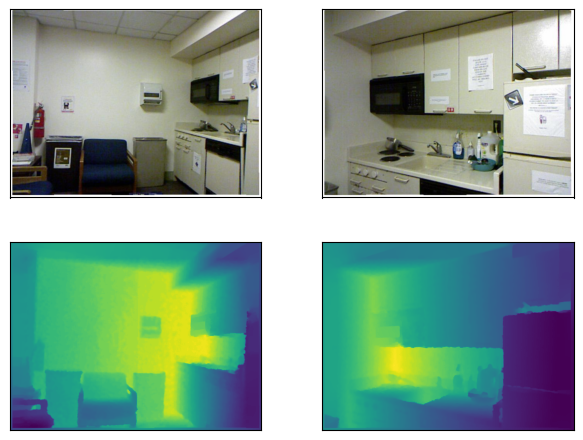

In [7]:
transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize(mean=(0, 0, 0), std=(255, 255, 255))
])

depth_transform = transforms.Compose([
	transforms.ToTensor()
])

NYU_data = NYUDepthDataset('data/NYU/nyu_depth_v2_labeled.mat', transform=transform, target_transform=depth_transform)
NYU_dataLoader = DataLoader(NYU_data, batch_size=5, shuffle=True, num_workers=0)

image_width, image_height = NYU_data[0][1].shape[1:]
num_shown = 2

def npImage(tensor):
	return np.swapaxes(np.swapaxes(tensor.detach().numpy(), 0, 2), 0, 1)

plot_images = [npImage(torch.mul(NYU_data[i][0], 255)) for i in range(num_shown)]
plot_images.extend([npImage(NYU_data[i][1]) for i in range(num_shown)])

print(f'Image Data: {len(NYU_data)} images of size {NYU_data[0][0].shape}')

show_grid((2, num_shown), plot_images)

# Initialising the Model

In [8]:
class fDense (nn.Module):
	layers = []
	def __init__(self, inChannels, outChannels, l=4, k=32):
		super().__init__()
		self.layers = []
		for i in range(l):
			# the input channel count for layer i+1 is k_{i+1} = k_0 + ik
			layerInputChannels = inChannels + k*i

			self.layers.append(nn.Sequential(
				nn.BatchNorm2d(layerInputChannels),
				nn.ReLU(),
				nn.Conv2d(layerInputChannels, k, 3, stride=1, padding=1)
			))
		
		# 1x1 convolution to remap to correct channel number
		self.layers.append(nn.Conv2d(inChannels + k*l, outChannels, 1))

	def forward(self, x):
		# TODO make numpy arr
		layerOutputs = [x]

		for layer in self.layers:
			layerOutputs.append(layer(torch.cat(layerOutputs, dim=1)))
		
		return layerOutputs[-1]

In [9]:
class SE (nn.Module):
	def __init__(self, inChannels, outChannels, w, h):
		super().__init__()
		self.scalarUpsample = nn.Upsample((w, h))
		self.globalPool = nn.AvgPool2d((w, h))
		self.fc1 = nn.Linear(1, 1)
		self.fc2 = nn.Linear(1, 1)

		self.conv = nn.Conv2d(inChannels, outChannels, 1)

	def forward(self, x):
		scalars = self.globalPool(x)
		scalars = F.relu(self.fc1(scalars))
		scalars = F.sigmoid(self.fc2(scalars))
		scalars = self.scalarUpsample(scalars)
		x = self.conv(torch.mul(x, scalars))
		return x

In [10]:
class DisparityConvolution (nn.Module):
	def __init__(self, inChannels):
		super().__init__()
		self.conv = nn.Conv2d(inChannels, 1, 3, stride=1, padding=1)
	
	def forward(self, x):
		# paper uses sigmoid, switching to relu for data
		# x = F.sigmoid(self.conv(x))
		x = F.relu(self.conv(x))
		return x

In [11]:
class FastMDE (nn.Module):
	inputSize = (0, 0)
	layers = []

	def __init__(self, w, h):
		super().__init__()
		self.inputSize = (w, h)

		self.pool = nn.MaxPool2d(2)
		self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

		# several layers of increasing channels and decreasing resolutions
		
		self.feature1 = nn.Sequential(nn.Conv2d(3, 16, 3, stride=1, padding=1), self.pool)
		self.feature2 = nn.Sequential(nn.Conv2d(16, 24, 3, stride=1, padding=1), self.pool)
		self.feature3 = nn.Sequential(nn.Conv2d(24, 32, 3, stride=1, padding=1), self.pool)
		self.feature4 = nn.Sequential(nn.Conv2d(32, 64, 3, stride=1, padding=1), self.pool)
		self.feature5 = nn.Sequential(nn.Conv2d(64, 128, 3, stride=1, padding=1), self.pool)

		self.ese4 = SE(192, 128, w//16, h//16)
		self.ese3 = SE(96, 64, w//8, h//8)
		self.ese2 = SE(56, 32, w//4, h//4)
		self.ese1 = SE(40, 24, w//2, h//2)

		self.fDense5 = nn.Sequential(fDense(128, 128), self.upsample)
		self.fDense4 = nn.Sequential(fDense(128, 128), self.upsample)
		self.fDense3 = nn.Sequential(fDense(64, 64), self.upsample)
		self.fDense2 = nn.Sequential(fDense(32, 32), self.upsample)
		self.fDense1 = nn.Sequential(fDense(72, 72), self.upsample)

		self.dse4 = nn.Sequential(nn.Conv2d(320, 320, 3, stride=1, padding=1), SE(320, 128, w//16, h//16))
		self.dse3 = nn.Sequential(nn.Conv2d(224, 224, 3, stride=1, padding=1), SE(224, 64, w//8, h//8))
		self.dse2 = nn.Sequential(nn.Conv2d(120, 120, 3, stride=1, padding=1), SE(120, 32, w//4, h//4))
		self.dse1 = nn.Sequential(nn.Conv2d(72, 72, 3, stride=1, padding=1), SE(72, 16, w, h))

		self.disparity = DisparityConvolution(16)

		print(self)

	def forward(self, x):
		layer1 = self.feature1(x)
		layer2 = self.feature2(layer1)
		layer3 = self.feature3(layer2)
		layer4 = self.feature4(layer3)
		layer5 = self.feature5(layer4)

		layer6 = self.ese4(torch.cat((self.upsample(layer5), layer4), dim=1))
		layer7 = self.ese3(torch.cat((self.upsample(layer4), layer3), dim=1))
		layer8 = self.ese2(torch.cat((self.upsample(layer3), layer2), dim=1))
		layer9 = self.ese1(torch.cat((self.upsample(layer2), layer1), dim=1))

		layer10 = self.fDense5(layer5)
		layer11 = self.dse4(torch.cat((layer10, layer6, layer4), dim=1))
		layer12 = self.fDense4(layer11)
		layer13 = self.dse3(torch.cat((layer12, layer7, layer3), dim=1))
		layer14 = self.fDense3(layer13)
		layer15 = self.dse2(torch.cat((layer14, layer8, layer2), dim=1))
		layer16 = self.fDense2(layer15)
		layer17 = self.fDense1(torch.cat((layer16, layer9, layer1), dim=1))
		layer18 = self.dse1(layer17)

		x = self.disparity(layer18)

		return x

In [12]:
model = FastMDE(image_width, image_height)

FastMDE(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upsample): Upsample(scale_factor=2.0, mode='nearest')
  (feature1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (feature2): Sequential(
    (0): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (feature3): Sequential(
    (0): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (feature4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (feature5): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


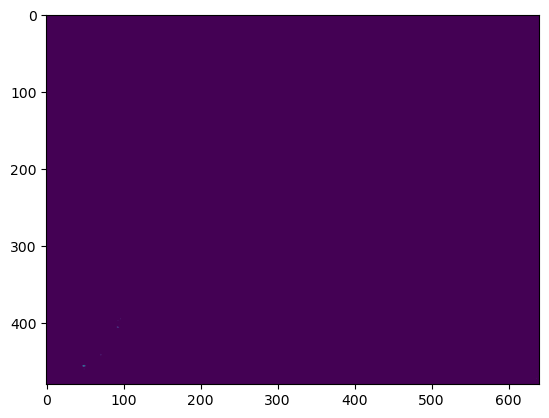

In [15]:
output = model.forward(torch.utils.data.default_collate([NYU_data[i][0] for i in range(2)]))

plt.imshow(npImage(output[0]))
print(output.detach().numpy()[0])

In [16]:
# https://ieeexplore-ieee-org.wv-o-ursus-proxy02.ursus.maine.edu/document/8205954

# but for now
criterion = nn.MSELoss()
optimizer = SGD(model.parameters(), lr=0.00001, momentum=0.9)

In [22]:
model.train(True)

avg_losses = []
for epoch in range(20):  # loop over the dataset multiple times
	print(f'-=-=-=-=- Epoch {epoch+1:02} -=-=-=-=-')
	running_loss = []
	for i, data in enumerate(NYU_dataLoader):
		# get the inputs; data is a list of [inputs, labels]
		inputs, labels = data
		inputs = inputs
		labels = labels

		# zero the parameter gradients
		optimizer.zero_grad()

		# forward + backward + optimize
		outputs = model(inputs)
		loss = criterion(outputs, labels)
		loss.backward()
		optimizer.step()

		# print statistics
		running_loss.append(loss.item())
		if i % 20 == 0:    # print every 100 mini-batches
			print(f'{i}/{len(NYU_dataLoader)}')
		# 	print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
		# 	running_loss = 0.0
	print(np.mean(running_loss))
	avg_losses.append(np.mean(running_loss))

print('Finished Training')

-=-=-=-=- Epoch 01 -=-=-=-=-
0/290
20/290
40/290
60/290
80/290
100/290
120/290
140/290
160/290
180/290
200/290
220/290
240/290
260/290
280/290
0.9999976063596792
-=-=-=-=- Epoch 02 -=-=-=-=-
0/290
20/290
40/290
60/290
80/290
100/290
120/290
140/290
160/290
180/290
200/290
220/290
240/290
260/290
280/290
0.9999975944387501
-=-=-=-=- Epoch 03 -=-=-=-=-
0/290
20/290
40/290
60/290
80/290
100/290
120/290
140/290
160/290
180/290
200/290
220/290
240/290
260/290


KeyboardInterrupt: 

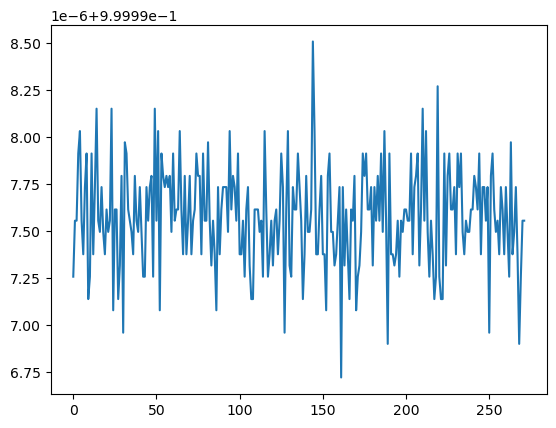

In [23]:
plt.plot(range(len(running_loss)), running_loss)

[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]


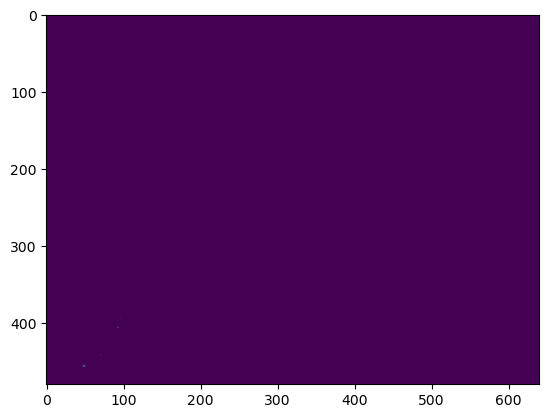

In [25]:
output = model.forward(torch.utils.data.default_collate([NYU_data[i][0] for i in range(2)]))

plt.imshow(npImage(output[0]))
print(output.detach().numpy()[0])

Image Data: 1449 images of size torch.Size([3, 480, 640])


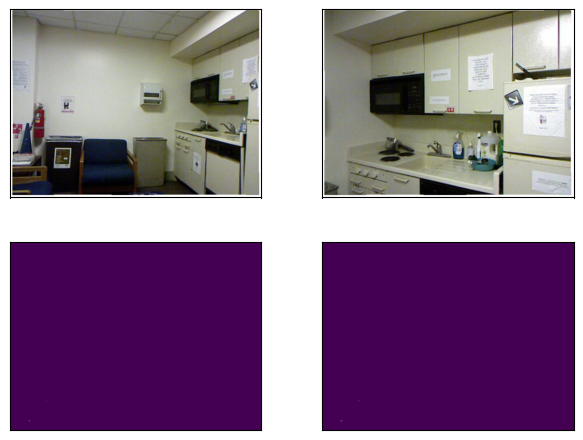

In [26]:
plot_images = [npImage(torch.mul(NYU_data[i][0], 255)) for i in range(num_shown)]
plot_images.extend([npImage(img) for img in output])

print(f'Image Data: {len(NYU_data)} images of size {NYU_data[0][0].shape}')

show_grid((2, num_shown), plot_images)

In [ ]:
def getNumParams(model):
	pp=0
	for p in list(model.parameters()):
		nn=1
		for s in list(p.size()):
			nn = nn*s
		pp += nn
	return pp

print(getNumParams(model))

1747825
